### Faster counting using sorting
This notebook demonstrates how sorting can be used to improve access locality. Here we use sorting in the context of a single CPU computation. The lessons are even more important in the context of a multi-CPU cluster, as will be shown in a separate notebook.

This notebook can be run without spark, using just Jupyter.

#### The task

We are given a text file, here we are using Moby Dick by Herman Melville which can be downloaded from [here](http://faculty.washington.edu/stepp/courses/2004autumn/tcss143/lectures/files/2004-11-08/mobydick.txt).

Our task is to read the file, separate it into words, make all words lower-case, and count the number of occurances of each word.

In [2]:
from string import lower,strip
import re
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Reading in the file
We read in the file, split it into words and create a list called `all` which contains all of the words in the document

In [4]:
%%time
import urllib
data_dir='../../Data'
filename='Moby-Dick.txt'

f = urllib.urlretrieve("https://mas-dse-open.s3.amazonaws.com/"+filename, data_dir+'/'+filename)

# Check that the text file is where we expect it to be
!ls -l $data_dir/$filename

-rw-rw-r-- 1 ubuntu ubuntu 1257260 Apr  1 00:06 ../../Data/Moby-Dick.txt
CPU times: user 10.4 ms, sys: 5.29 ms, total: 15.7 ms
Wall time: 224 ms


In [5]:
#%%time
file=open(data_dir+'/'+filename,'r')

all=[]
for line in file.readlines():
    line=lower(strip(line))
    if len(line)==0:
        continue
    words=[w for w in re.split(r'\W+',line) if len(w)>0]
    #print line, words
    all+=words
print 'the book contains',len(all),'words'

the book contains 221908 words


### Simple sort
First, lets try counting words using the most straight-forward approach.
We create a dictionary `D` and then go through the list of words `all`. For each word we increment the corresponding entry in `D` if the word exists as a key in the dictionary, if it is not in the dictionary, we add it to the dictionary

In [6]:
%%time
def simple_count(list):
    D={}
    for w in list:
        if w in D.keys():
            D[w]+=1
        else:
            D[w]=1
    return D
D=simple_count(all)

CPU times: user 54.8 s, sys: 33.5 ms, total: 54.8 s
Wall time: 54.5 s


### Simple count is slow!
It takes, on my laptop, about a minute to finish the counting.

We check that the output makes sense by printing the 10 most common words.

In [11]:
S=sorted(D.items(),key=lambda d:d[1],reverse=True)
S[:10]

[('the', 14620),
 ('of', 6732),
 ('and', 6502),
 ('a', 4799),
 ('to', 4706),
 ('in', 4230),
 ('that', 3100),
 ('it', 2536),
 ('his', 2530),
 ('i', 2127)]

### Sorted count
Next, we show a faster way to count. We first sort the words alphabetically. Then, when we iterate through the sorted list, all of the occurances of any word appear consecutively, allowing us to quickly count them using just one counter. This counter is added to the dictionary when this element of the list is different than the previous one.

In [12]:
%%time
def sort_count(list):
    S=sorted(list)
    D={}
    current=''
    count=0
    for w in S:
        if current==w:
            count+=1
        else:
            if current!='':
                D[current]=count
            count=1
            current=w
    return D
D=sort_count(all)

CPU times: user 134 ms, sys: 23.6 ms, total: 158 ms
Wall time: 142 ms


In [13]:
len(D)

17353

### Discussion
As we see, `sort_count` is about 350 times faster than `simple_count`. 

**why?**  
The reason is that sorting the list of words improves the locality of memory access for the table `D`. 
`simple_count` accesses the elements in `D` in the order of the words in the text. In natural text you rarely see the same word appearing several times consecutively. As there are likely to be large gaps between occurances of the same word, when an element of `D` needs to be updated, it is unlikely to be in the cache. The result is a large number of cache misses, resulting in a long run time.

In contrast, after the words are sorted, all of the occurances of each word are consecutive. This means that sort_count makes exactly one write access to create each element of `D`, and will never require this element again.

Below is a printout of a segment of the original list and a printout of a segment of the sorted list. In fact, if you pick a random segment of the sorted list, it is likely to consist of repetitions of a single word.

In [14]:
print '=== unsorted list:'
print ','.join(all[100214:100240])
S=sorted(all)
print '=== sorted list:'
print ','.join(S[100214:100240])

=== unsorted list:
mizzen,rigging,like,three,quarters,of,meat,and,there,they,hung,till,morning,damn,ye,cried,the,captain,pacing,to,and,fro,before,them,the,vultures
=== sorted list:
leviathan,leviathan,leviathan,leviathan,leviathan,leviathan,leviathan,leviathan,leviathan,leviathan,leviathan,leviathan,leviathan,leviathan,leviathan,leviathan,leviathan,leviathan,leviathan,leviathanic,leviathanic,leviathanic,leviathanic,leviathanic,leviathanic,leviathanic


### Built in Counter
Another way to achieve good performance is to use `Counter` from the standard python library [collections](https://docs.python.org/2/library/collections.html)

We include this here for the sake of comparison

In [15]:
from collections import Counter

### Performance scaling
We now run the three counting methods: `simple`, `sort` and `counter` on lists of different length and then plot the performances on a log-log scale.

Why do we use log-log graphs?
1. Because it makes visible the performance across several orders of magnitude.
2. Because if the relationship between the list length $n$ and the run time $t$ is of the form $t=n^\alpha$ then the relationship between $t$ and $n$ on the log-log scale appears linear, with a slope of $\alpha$.

In [16]:
from time import time
l=len(all)
Ln=[];Lsimple=[];Lsort=[];Lcounter=[]
for i in range(10):
    time1=time()
    n=l/(2**i)
    simple_count(all[:n])
    time2=time()
    sort_count(all[:n])
    time3=time()
    Counter(all[:n])
    time4=time()
    Ln.append(n)
    t_simple=time2-time1; Lsimple.append(t_simple)
    t_sort=time3-time2; Lsort.append(t_sort)
    t_counter=time4-time3; Lcounter.append(t_counter)

    print 'len=%5d, simple=%f, sort=%f, counter=%f'%(n,t_simple,t_sort,t_counter)
 

len=221908, simple=55.510008, sort=0.132251, counter=0.087407
len=110954, simple=18.541071, sort=0.059672, counter=0.038881
len=55477, simple=5.778270, sort=0.026980, counter=0.019452
len=27738, simple=1.533418, sort=0.014454, counter=0.009447
len=13869, simple=0.542560, sort=0.007097, counter=0.004699
len= 6934, simple=0.180364, sort=0.003434, counter=0.002313
len= 3467, simple=0.040977, sort=0.001659, counter=0.001485
len= 1733, simple=0.013797, sort=0.000701, counter=0.000697
len=  866, simple=0.003809, sort=0.000499, counter=0.000361
len=  433, simple=0.001095, sort=0.000166, counter=0.000195


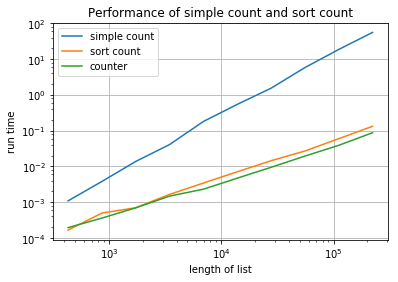

In [17]:
loglog(Ln,Lsimple,label='simple count');
loglog(Ln,Lsort,label='sort count');
loglog(Ln,Lcounter,label='counter')
grid();
title('Performance of simple count and sort count')
legend(loc='best')
xlabel('length of list')
ylabel('run time');

### Conclusions
We see from the graph that `sort` and `counter` have very similar run times, and are both better than `simple`. The gap between `sort` and `simple` increases as the length of the list increases. This makes sense because the longer the list, the higher the frequency of cache misses.

We also see that while for `sort` and `counter` the relationship is approximately linear $t \approx n$. The relation for `simple` is of the form $t \approx n^{1.5}$

In [ ]:
import os
import sys
testPath = '/'.join(os.getcwd().split('/')[:-1]) + "/Tester/SimpleCount"
sys.path.insert(0, testPath )
pickleFile = testPath+ "/SimpleCount.pkl"
import SimpleCount

### Exercise 1 

A `k`-mer is a sequence of `k` consecutive words. 

For example, the `3`-mers in the line `you are my sunshine my only sunsine` are

* `you are my`
* `are my sunshine`
* `my sunshine my`
* `sunshine my only`
* `my only sunsine`

For the sake of simplicity we consider only the `k`-mers that appear in a single line. In other words, we ignore `k`-mers that span more than one line.

Write a function, to return the list of `k`-mers in a given text for a given `k`.

#### Input
    text = ['you are my sunshine my only sunsine']

#### Output 
    ['you are my', 'are my sunshine', 'my sunshine my', 'sunshine my only', 'my only sunsine']

In [ ]:
def compute_kmers(text,k):
    kmers = []
    # your implementation goes here
    return kmers

In [ ]:
import SimpleCount
SimpleCount.exercise0_1(pickleFile, compute_kmers)

### Exercise 2

Give a list of k-mers, Write a function, to return the dictionary with key as `k`-mer and value as the number of times (count) it has occurred in the input list.

#### Input
    kmers = ['you are my', 'are my sunshine', 'my sunshine my', 'sunshine my only', 'my only sunsine']

#### Output 
    {'you are my' : 1, 'are my sunshine' : 1, 'my sunshine my' : 1, 'sunshine my only' : 1, 'my only sunsine' : 1}

In [ ]:
def count_kmers(kmers):
    kmers_count = dict()
    # your implementation goes here 
    return kmers_count

In [ ]:
import SimpleCount
SimpleCount.exercise0_2(pickleFile, compute_kmers)

### Exercise 3 

Give a dictionary of k-mer as key and its count , Write a function, to sort the k-mers in descending order of its count and return a list of tuples. 

    * Each tuple is of the form (kmer, count). 
    * If two k-mers have same count, then sort the lexicographically.
    
#### Input
    count_kmers =  {'you are my' : 1, 'are my sunshine' : 1, 'my sunshine my' : 1, 'sunshine my only' : 1, 'my only sunsine' : 1}

#### Output 
    [('are my sunshine', 1) , ('my only sunsine' , 1) , ('my sunshine my', 1), ('sunshine my only', 1) , ('you are my', 1)]

In [ ]:
def sort_counts(kmer_counts):
    sorted_counts = None
    # your implementation goes here
    return sorted_counts

### Exercise 4 

Given a list of text lines, Write a function, to return the list of tuples containing top `n` k-mers with its count  for a given n, k.
    
#### Input
    n = 2, k = 3
    text = ['you are my sunshine my only sunsine']

#### Output 
    [('are my sunshine', 1) , ('my only sunsine' , 1)]

In [1]:
def get_top_n_kmers(text,n,k):
    kmers = compute_kmers(text,k)
    kmers_count = count_kmers(kmers)
    sorted_counts = sort_counts(kmers_count)
    #SOLUTION BEGINS
    top_n_kmers = None
    #SOLUTION ENDS
    print 'most common %d-mers\n'%k,'\n'.join(['%d:\t%s'%c for c in C])
    return top_n_kmers